# Hippocampal CA3 Region Model with Spiking Neural Networks

This notebook simulates a simplified model of the hippocampal CA3 region using spiking neural networks (SNNs). The model includes both excitatory and inhibitory neurons, with synaptic plasticity based on spike-timing-dependent plasticity (STDP). Let's explore the code step by step, with explanations linking the biological aspects to the computational model.


## Import Libraries

We start by importing the necessary libraries: Brian2 for the simulation and NumPy and Matplotlib for data handling and plotting.


In [1]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

# Set simulation parameters
duration = 1 * b2.second
num_excitatory = 80
num_inhibitory = 20

# Total number of neurons
num_neurons = num_excitatory + num_inhibitory


## Neuron Model: Leaky Integrate-and-Fire (LIF)

The hippocampal CA3 region contains both excitatory neurons (using glutamate) and inhibitory neurons (using GABA). We'll model these using the Leaky Integrate-and-Fire (LIF) model.

### Equations:
- **Membrane Potential (v)**: Represents the voltage across the neuron's membrane.
- **Input Current (I)**: Represents synaptic input from other neurons.
- **Membrane Time Constant (tau)**: Describes how quickly the membrane potential decays over time.


In [2]:
# Define neuron model equations
eqs_excitatory = '''
dv/dt = (I-v) / tau : volt (unless refractory)
I : volt
tau : second
'''
eqs_inhibitory = '''
dv/dt = (I-v) / tau : volt (unless refractory)
I : volt
tau : second
'''


## Neuron Initialization

We initialize the neurons' membrane potentials, input currents, and membrane time constants to reflect biological variability.

- **Resting Potential**: Set to -70 mV for all neurons.
- **Input Current**: Random for each neuron.
- **Membrane Time Constant**: Randomly varied for excitatory and inhibitory neurons.


In [3]:
# Create excitatory and inhibitory neuron groups
exc_neurons = b2.NeuronGroup(num_excitatory, eqs_excitatory, threshold='v > -50*mV', reset='v = -70*mV', refractory=5*b2.ms, method='exact')
inh_neurons = b2.NeuronGroup(num_inhibitory, eqs_inhibitory, threshold='v > -50*mV', reset='v = -70*mV', refractory=2*b2.ms, method='exact')


# Initialize membrane potential and input current
exc_neurons.v = -70 * b2.mV
inh_neurons.v = -70 * b2.mV
exc_neurons.I = '10*mV * rand()'
inh_neurons.I = '10*mV * rand()'
exc_neurons.tau = '10*ms + 5*ms * randn()'
inh_neurons.tau = '10*ms + 2*ms * randn()'


## Synaptic Connections and STDP

Neurons communicate via synapses. Here, we define excitatory and inhibitory synapses with specific properties:

### Synaptic Plasticity
We use spike-timing-dependent plasticity (STDP) for excitatory synapses, adjusting synaptic strength based on the timing of pre- and post-synaptic spikes. This mechanism is crucial for learning and memory in the brain.

#### Equations:
- **Apre and Apost**: Variables tracking changes in synaptic strength.
- **tau_pre and tau_post**: Time constants for the decay of Apre and Apost.
- **dApre and dApost**: Parameters determining the magnitude of synaptic changes.
- **wmax**: Maximum synaptic weight.


In [4]:
# STDP model equations
stdp_eqs = '''
w : 1
dApre/dt = -Apre/tau_pre : 1 (event-driven)
dApost/dt = -Apost/tau_post : 1 (event-driven)
'''

on_pre = '''
v_post += w*mV
Apre += dApre
w = clip(w + Apost, 0, wmax)
'''

on_post = '''
Apost += dApost
w = clip(w + Apre, 0, wmax)
'''

# STDP parameters
tau_pre = 20*b2.ms
tau_post = 20*b2.ms
dApre = 0.01
dApost = -dApre * tau_pre / tau_post * 1.05
wmax = 1.0

## Synaptic Connections

We define the connections between neurons, setting up excitatory and inhibitory synapses with appropriate connection probabilities and synaptic weights.


In [5]:
# Excitatory to excitatory synapses with STDP
exc_synapses = b2.Synapses(exc_neurons, exc_neurons, model=stdp_eqs, on_pre=on_pre, on_post=on_post, method='linear')
exc_synapses.connect(p=0.1)
exc_synapses.w = '0.2 + 0.2*rand()'

# Inhibitory to excitatory synapses
inh_synapses = b2.Synapses(inh_neurons, exc_neurons, model='w : 1', on_pre='v_post -= w*mV', method='linear')
inh_synapses.connect(p=0.1)
inh_synapses.w = '0.5 + 0.5*rand()'

## Monitoring Neural Activity

We set up monitors to record spikes and membrane potentials. This data will help us visualize the dynamics of the neural network.

- **SpikeMonitor**: Records the times at which neurons fire.
- **StateMonitor**: Records the membrane potentials over time.


In [ ]:
# Set up monitors
spike_monitor_exc = b2.SpikeMonitor(exc_neurons)
spike_monitor_inh = b2.SpikeMonitor(inh_neurons)
state_monitor_exc = b2.StateMonitor(exc_neurons, 'v', record=True)
state_monitor_inh = b2.StateMonitor(inh_neurons, 'v', record=True)

# Run the simulation
b2.run(duration)


## Visualization

We visualize the results using Matplotlib to create spike raster plots and membrane potential plots. These plots help us understand the activity patterns of excitatory and inhibitory neurons.

- Spike Raster Plot: Shows the timing of spikes for excitatory and inhibitory neurons.
- Membrane Potential Plot: Shows the membrane potential changes over time for a subset of neurons.


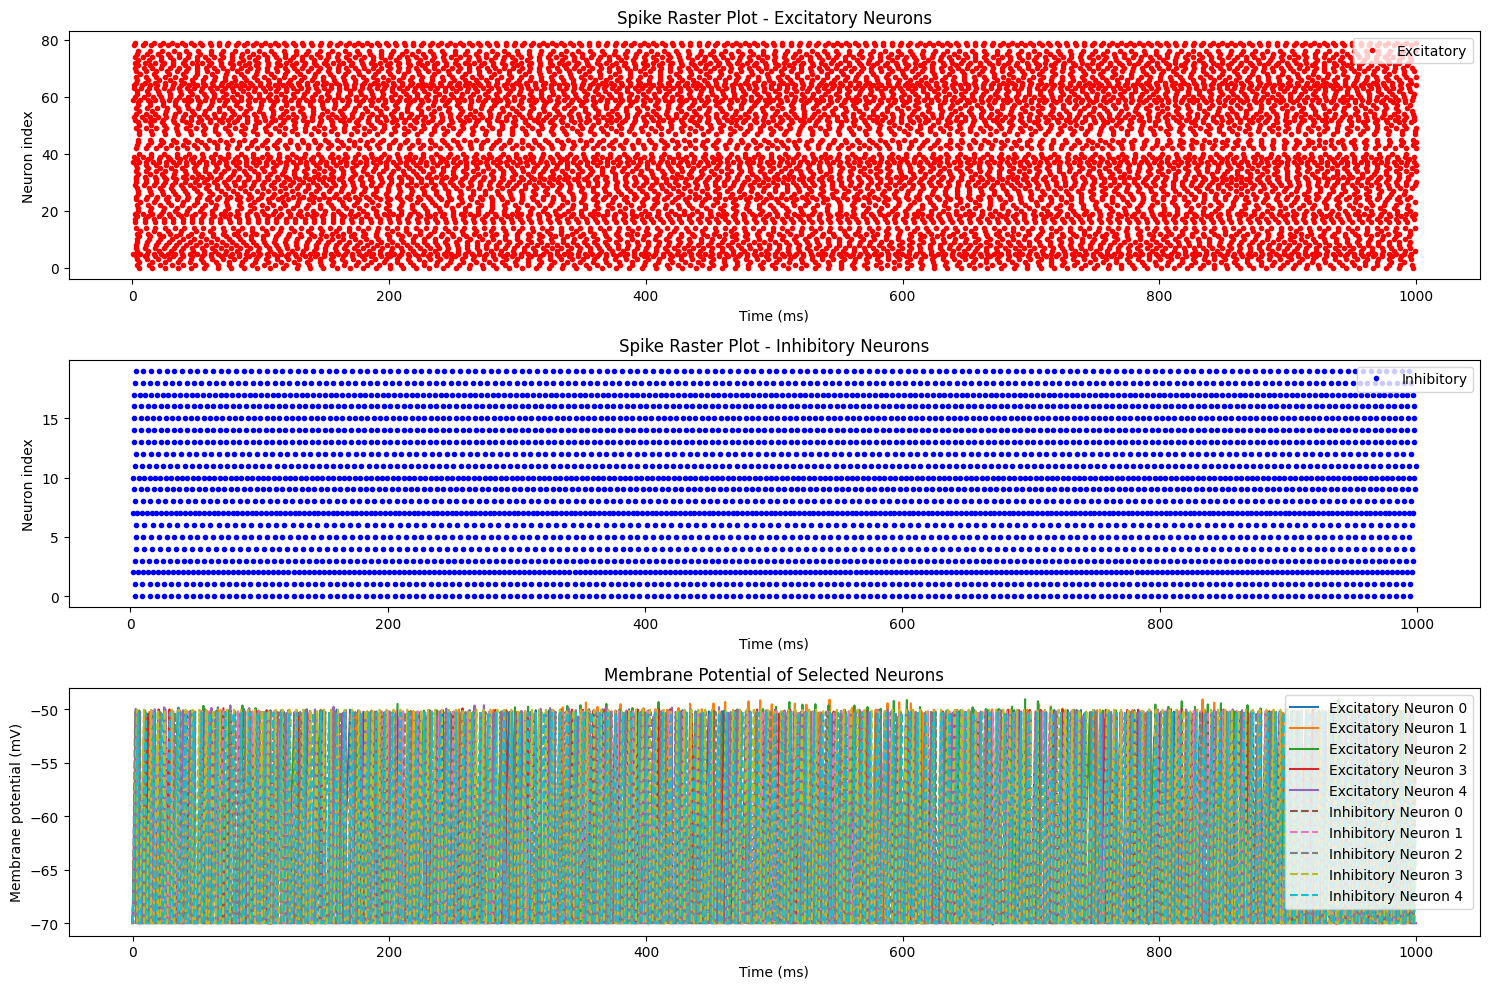

In [7]:
# Plot the results
plt.figure(figsize=(15, 10))

# Spike Raster Plot for Excitatory Neurons
plt.subplot(311)
plt.plot(spike_monitor_exc.t/b2.ms, spike_monitor_exc.i, '.r', label='Excitatory')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot - Excitatory Neurons')
plt.legend()

# Spike Raster Plot for Inhibitory Neurons
plt.subplot(312)
plt.plot(spike_monitor_inh.t/b2.ms, spike_monitor_inh.i, '.b', label='Inhibitory')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot - Inhibitory Neurons')
plt.legend()

# Membrane Potential of a Subset of Neurons
plt.subplot(313)
for idx in range(min(num_excitatory, 5)):
 plt.plot(state_monitor_exc.t/b2.ms, state_monitor_exc.v[idx]/b2.mV, label=f'Excitatory Neuron {idx}')
for idx in range(min(num_inhibitory, 5)):
 plt.plot(state_monitor_inh.t/b2.ms, state_monitor_inh.v[idx]/b2.mV, label=f'Inhibitory Neuron {idx}', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane Potential of Selected Neurons')
plt.legend()

plt.tight_layout()
plt.show()


## Biological Insights

1. Network Composition: The mix of excitatory and inhibitory neurons reflects the balance seen in the brain, which is crucial for proper functioning and stability of neural circuits.
2. Synaptic Plasticity: STDP represents how the brain learns and adapts by strengthening or weakening synapses based on experience and activity.
3. Neuronal Dynamics: The LIF model, although simplified, captures essential properties of neuronal dynamics such as spiking behavior and refractory periods.
4. Connectivity Patterns: The random connectivity and varying synaptic strengths mimic the complex and heterogeneous connectivity found in real neural circuits.

By incorporating these biologically plausible mechanisms, the model aims to replicate certain aspects of brain function and provide insights into the dynamics of neural networks.